In [46]:
import numpy as np
import matplotlib.pyplot as plt

import torch,torchvision

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets,transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

In [47]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
data_target=data*0.5+0.5
data=data.view(60000,784)
data=data.to(dtype=torch.float32)

data_target=data_target.view(60000,784)
trainset=TensorDataset(data,data_target)
trainloader=DataLoader(trainset,batch_size=256,shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

In [48]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, x, y, z):
        loss = -x +y -z
        loss = torch.mean(loss,dim=0)
        return loss

In [49]:
class CustomLoss2(nn.Module):
  def __init__(self):
    super(CustomLoss2,self).__init__()

  def forward(self,rce,kl,a=0.37,b=0.63):
    expected_rce = torch.mean(rce)
    kl_loss=torch.mean(kl)
    loss= a*expected_rce + b*kl_loss
    return loss

In [50]:
class VAE(nn.Module):
    def __init__(self,latent_dim):
      super(VAE,self).__init__()

      self.latent_dim=latent_dim
      self.fc1=nn.Linear(784,400)
      self.fc2=nn.Linear(400,400)
      self.fc3=nn.Linear(400,2*latent_dim)
      self.fc4=nn.Linear(latent_dim,256)
      self.fc5=nn.Linear(256,400)
      self.fc6=nn.Linear(400,784)
      init.xavier_uniform_(self.fc1.weight)
      init.xavier_uniform_(self.fc2.weight)
      init.xavier_uniform_(self.fc3.weight)
      init.xavier_uniform_(self.fc4.weight)
      init.xavier_uniform_(self.fc5.weight)
      init.xavier_uniform_(self.fc6.weight)
      self.bn1 = nn.BatchNorm1d(400)
      self.bn2 = nn.BatchNorm1d(400)
      self.bn3 = nn.BatchNorm1d(2*latent_dim)
      self.bn4 = nn.BatchNorm1d(256)
      self.bn5 = nn.BatchNorm1d(400)
      self.epsilon=1e-8

    def decoder(self,z):
      x = F.relu(self.bn4(self.fc4(z)))
      x = F.relu(self.bn5(self.fc5(x)))
      x = torch.sigmoid(self.fc6(x))
      return x

    def encoder(self,x):
      noise=torch.randn(self.latent_dim)
      noise=noise.to('cuda:0')
      x = F.relu(self.bn1(self.fc1(x)))
      #x = F.relu(self.bn2(self.fc2(x)))
      x = F.relu(self.bn3(self.fc3(x)))
      u,v=x[:,:self.latent_dim],x[:,self.latent_dim:]
      x=u+torch.exp(0.5*v)*noise
      return x,u,v


    def reconstruction_error(self, x_or, x_re):
        x_or = 0.5 * x_or + 0.5
        x_or = torch.clamp(x_or, 0.0, 1.0)  # Avoid values outside [0, 1]
        x_re = self.epsilon + x_re
        re_loss = -torch.sum(x_or * torch.log(x_re) + (1 - x_or) * torch.log(1 - x_re), dim=1)
        return re_loss

    def KL_div(self, z_mean, z_log_var):
        z_std = torch.exp(0.5 * z_log_var)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_std.pow(2), dim=1)
        return kl_loss


    def forward(self,x):
      original_x=x
      z,z_mean,z_var=self.encoder(x)
      x=self.decoder(z)
      reconstruction_error=self.reconstruction_error(original_x,x)
      Kl=self.KL_div(z_mean,z_var)
      return reconstruction_error,Kl



In [51]:
lr_rate=0.001
num_epochs=1000

In [59]:
model=VAE(10)
criterion=CustomLoss2()
optimizer=optim.Adam(model.parameters(),lr=lr_rate)
model=model.to('cuda:0')

In [60]:
loss_list=[]
for epoch in range(num_epochs):
  model.train()
  total_loss=0
  count=0
  for input,target in trainloader:
    #input=torch.rand(input.shape[0],input.shape[1])
    input=input.to('cuda:0')
    x,y=model(input)

    loss=criterion(x,y)
    total_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count+=1

  print(total_loss/count)
  loss_list.append(total_loss)
  print(f'training_loss={total_loss},epoch={epoch}')

58.61621907010991
training_loss=13774.81148147583,epoch=0
41.909045864673374
training_loss=9848.625778198242,epoch=1
38.5101999972729
training_loss=9049.89699935913,epoch=2
36.69814696616315
training_loss=8624.06453704834,epoch=3
35.50111752773853
training_loss=8342.762619018555,epoch=4
34.55616688018149
training_loss=8120.699216842651,epoch=5
33.791492023873836
training_loss=7941.000625610352,epoch=6
33.187253757233314
training_loss=7799.004632949829,epoch=7
32.68568278373556
training_loss=7681.135454177856,epoch=8
32.26061670019271
training_loss=7581.244924545288,epoch=9
31.94442953556142
training_loss=7506.940940856934,epoch=10
31.652013364751287
training_loss=7438.223140716553,epoch=11
31.424754163052175
training_loss=7384.817228317261,epoch=12
31.174871485284033
training_loss=7326.094799041748,epoch=13
31.007852310829975
training_loss=7286.845293045044,epoch=14
30.810259068265875
training_loss=7240.4108810424805,epoch=15
30.668166383783866
training_loss=7207.019100189209,epoch=16


KeyboardInterrupt: 

In [ ]:
print(model.fc1.weight)

torch.Size([256, 10])
torch.Size([784])


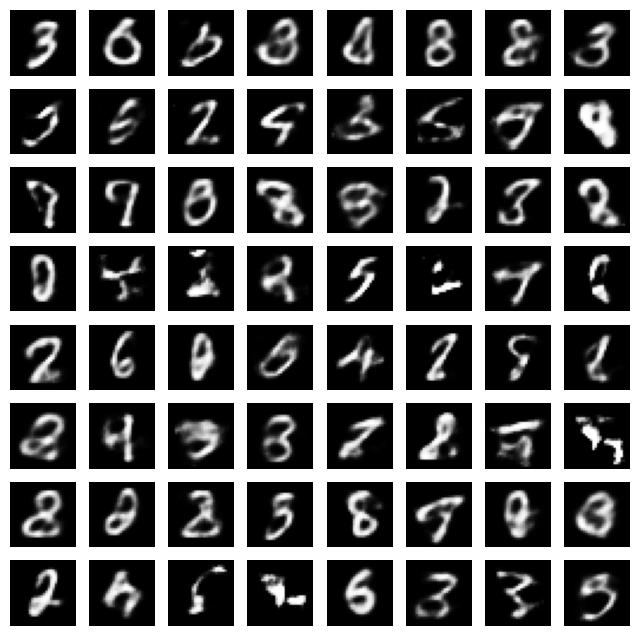

In [72]:
with torch.no_grad():
  #model.eval()
  x=data[:256]
  #print(x)
  x=torch.randn(256,784)
  x=x.to('cuda:0')
  z=model.encoder(x)
  z=z[0].to('cuda:0')
  print(z.shape)
  z=z+z
  x=model.decoder(z)
  print(x[0].shape)
  x = x[:64].view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.detach().numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()

torch.Size([10])
tensor([0.0000, 0.0159, 0.0317, 0.0476, 0.0635, 0.0794, 0.0952, 0.1111, 0.1270,
        0.1429, 0.1587, 0.1746, 0.1905, 0.2063, 0.2222, 0.2381, 0.2540, 0.2698,
        0.2857, 0.3016, 0.3175, 0.3333, 0.3492, 0.3651, 0.3810, 0.3968, 0.4127,
        0.4286, 0.4444, 0.4603, 0.4762, 0.4921, 0.5079, 0.5238, 0.5397, 0.5556,
        0.5714, 0.5873, 0.6032, 0.6190, 0.6349, 0.6508, 0.6667, 0.6825, 0.6984,
        0.7143, 0.7302, 0.7460, 0.7619, 0.7778, 0.7937, 0.8095, 0.8254, 0.8413,
        0.8571, 0.8730, 0.8889, 0.9048, 0.9206, 0.9365, 0.9524, 0.9683, 0.9841,
        1.0000], device='cuda:0')


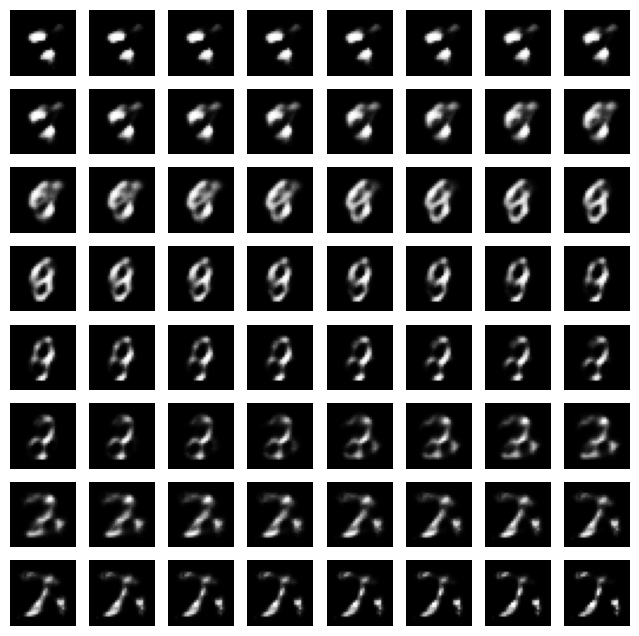

In [71]:
with torch.no_grad():
    #model.eval()
    z0=z[0]
    z1=z[1]
    print(z1.shape)
    num_interpolations = 64
    alphas = torch.linspace(0, 1,64 ).to('cuda:0')
    print(alphas)
    interpolated_vectors = ((1 - alphas.view(-1, 1)) * z0 )+ (alphas.view(-1, 1) * z1)
    z2=interpolated_vectors
    x=model.decoder(interpolated_vectors)
    #print(x[0].shape)
    x = x[:64].view(8, 8, 28, 28)
    x = x.to('cpu')
    image_np = x.detach().numpy()

    # Create a figure and a set of subplots arranged in an 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))

    # Iterate through the subplots and display each image
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(image_np[i, j], cmap='gray')
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()



In [ ]:
torch.pi

In [ ]:
'''import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 400)
        self.fc6 = nn.Linear(400, 784 * 2)

    def decoder(self, z):
        noise = torch.randn(784)
        x = F.relu(self.fc4(z))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        u, v = x[:784], x[784:]
        x = u + v * noise
        return x, u, v

    def encoder(self, x):
        noise = torch.randn(128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        u, v = x[:128], x[128:]
        x = u + v * noise
        return x, u, v

    def forward(self, x):
        z, z_mean, z_var = self.encoder(x)
        inter_z = (z - z_mean) ** 2
        z_var_sq = z_var ** 2
        prob_z = -torch.log(z_var) - torch.div(inter_z, z_var_sq) - torch.log(2.50)

        prob_z_or = -torch.log((z / 2) ** 2) - torch.log(2.50)

        x, x_mean, x_var = self.decoder(z)
        inter_x = (x - x_mean) ** 2
        x_var_sq = x_var ** 2
        prob_x = -torch.log(x_var) - torch.div(inter_x, x_var_sq) - torch.log(2.50)

        return prob_z, prob_x, prob_z_or'''


In [ ]:
    def calculate_log_prob_z(self,z, z_mean, z_var):
      k = z.shape[1]
      pi = torch.tensor(3.14159265358979323846)
      log_det_sigma = torch.sum(torch.log(z_var+self.epsilon), dim=1)
      exponent_term = -0.5 * torch.sum((z - z_mean)**2 / (z_var**2+self.epsilon), dim=1)
      log_prob_z = -0.5 * k * torch.log(2 * pi) - log_det_sigma - exponent_term
      return log_prob_z


    def forward2(self,x):
      z,z_mean,z_var=self.encoder(x)
      x,x_mean,x_var=self.decoder(z)

      k = z.shape[1]
      pi = torch.tensor(3.14159265358979323846)
      log_prob_z=self.calculate_log_prob_z(z,z_mean,z_var)
      log_prob_z_or=-0.5 * k * torch.log(2 * pi) - 0.5 * torch.sum((z - 0)**2,dim=1)
      log_prob_x=self.calculate_log_prob_z(x,x_mean,x_var)

      return log_prob_z,log_prob_x,log_prob_z_or

In [ ]:
import torch

# Instantiate your CustomLoss
custom_loss = CustomLoss()

# Set requires_grad=True to track the gradients
x = torch.randn((10, 1), requires_grad=True)
y = torch.randn((10, 1), requires_grad=True)
z = torch.randn((10, 1), requires_grad=True)

print(x,y,z)
# Forward pass
output = custom_loss(x, y, z)

# Backward pass
output.backward()

# Access the gradients
gradient_x = x.grad
gradient_y = y.grad
gradient_z = z.grad

print("Gradient of x:")
print(gradient_x)

print("\nGradient of y:")
print(gradient_y)

print("\nGradient of z:")
print(gradient_z)


In [ ]:
    print(model.fc1.weight,'8')
    for name, param in model.named_parameters():
          if param.requires_grad and param.grad is not None:
              print(f'Gradient for {name}:')
              print(param.grad)

    x,y=model(input)
    #print(list(model.parameters()))

          #if 1!=0:
      #  recons=(x_or-x_mean)**2
      #  epsilon=1e-8
      #  x_var=torch.reciprocal(x_var+epsilon)**2
      #  recons=recons*x_var
      #  loss=torch.sum(recons,dim=1)
      #else: